-------
RESULTS

Peaks at 2, 10, and 22Hz

\paragraph{Audio VS Vibro:}

-  Higher Beta for Vibro in All Regions
-  Lower (Delta and) Theta for Vibro in Frontal Electrodes

\paragraph{Audio VS Shape:}

-  Higher Beta for Shape in All Regions
- Higher Gamma for Shape in Frontal Electrodes
-  Lower Delta for Shape in Frontal ELectrodes 
- Higher Alpha for Shape in AF8

\paragraph{Shape VS Vibro:}
-  No statistical difference between Shape and Vibro


Overall: 

	- Shape much similar Power Distribution (HIGH) to Auditory in lower frequency bands compared to Vibro (LOW)
 
    - Shape much similar Power Distribution (HIGH) to Vibro in higher frequency bands compared to Audio (LOW)


-------
Get Clean Data
-------

In [277]:
import numpy as np
from matplotlib import pyplot as plt
import mne, os
import json

with open('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\results_data\\Outliers_7030.json', 'r') as file:
    data = json.load(file)
keys_below_30 = []
for key, values in data.items():
    if all(value < 50 for value in values):
        key = key.replace('.json', '.fif')
        keys_below_30.append(key)

to_add = ['VibroVisual_10_2.fif','VibroVisual_02_2.fif','VibroVisual_03_1.fif','VibroVisual_03_2.fif']
for i in to_add:
    keys_below_30.append(i)

print(keys_below_30)

raw_folder = os.path.join(os.path.expanduser('~/'),'Desktop', 'FYP', 'code_env', 'eeg-notebooks','FYP', 'data_ordered', 'mne_raw')
raw_files_all = [file for file in os.listdir(raw_folder) if file.endswith(".fif")]

['AudioVisual_04_1.fif', 'AudioVisual_04_2.fif', 'AudioVisual_06_1.fif', 'AudioVisual_06_2.fif', 'ShapeVisual_01_1.fif', 'ShapeVisual_01_2.fif', 'ShapeVisual_02_2.fif', 'ShapeVisual_03_1.fif', 'ShapeVisual_03_2.fif', 'ShapeVisual_04_1.fif', 'ShapeVisual_04_2.fif', 'ShapeVisual_06_2.fif', 'ShapeVisual_07_2.fif', 'ShapeVisual_09_1.fif', 'ShapeVisual_10_1.fif', 'ShapeVisual_10_2.fif', 'ShapeVisual_11_1.fif', 'ShapeVisual_11_2.fif', 'VibroVisual_06_1.fif', 'VibroVisual_10_2.fif', 'VibroVisual_02_2.fif', 'VibroVisual_03_1.fif', 'VibroVisual_03_2.fif']


In [273]:
raw_folder = os.path.join(os.path.expanduser('~/'), 'Desktop', 'FYP', 'code_env', 'eeg-notebooks', 'FYP', 'data_ordered', 'mne_raw')
files_clean = [file for file in keys_below_30]
files_all = [file for file in os.listdir(raw_folder) if '_2.fif' in file]


In [292]:

#-----SET FILE SELECTION
raw_files = files_clean
trial = False

if trial:
    psd_data = {
        'Audio01': [],
        'Vibro01': [],
        'Shape01': [],
        'Audio02': [],
        'Vibro02': [],
        'Shape02': []
    }
else:
    psd_data = {
        'Audio': [],
        'Vibro': [],
        'Shape': []
    }

for file in raw_files:
    print("Computing PSD analysis for trial", file)
    raw_path = os.path.join(raw_folder, file)
    raw = mne.io.read_raw_fif(raw_path, preload=True)
    data = raw.get_data()

    # Determine the modality based on the file name
    if trial:
        if '_1.' in file:
            if 'Audio' in file:
                modality = 'Audio01'
            elif 'Vibro' in file:
                modality = 'Vibro01'
            elif 'Shape' in file:
                modality = 'Shape01'
        else:
            if 'Audio' in file:
                modality = 'Audio02'
            elif 'Vibro' in file:
                modality = 'Vibro02'
            elif 'Shape' in file:
                modality = 'Shape02'
    else:
        if 'Audio' in file:
            modality = 'Audio'
        elif 'Vibro' in file:
            modality = 'Vibro'
        elif 'Shape' in file:
            modality = 'Shape'


    # Compute the power spectrum for each channel
    psd_array = []
    for ch in range(data.shape[0]):
        psd, freqs = mne.time_frequency.psd_array_welch(data[ch], sfreq=raw.info['sfreq'])
        psd_array.append(psd)

    psd_data[modality].append(psd_array)

# Save the PSD data dictionary to a file
np.save('var\\psd_data.npy', psd_data) # ----SET FILE NAME
print("PSD data saved to 'var\\psd_data.npy'")


Computing PSD analysis for trial AudioVisual_04_1.fif
Computing PSD analysis for trial AudioVisual_04_2.fif
Computing PSD analysis for trial AudioVisual_06_1.fif
Computing PSD analysis for trial AudioVisual_06_2.fif
Computing PSD analysis for trial ShapeVisual_01_1.fif
Computing PSD analysis for trial ShapeVisual_01_2.fif
Computing PSD analysis for trial ShapeVisual_02_2.fif
Computing PSD analysis for trial ShapeVisual_03_1.fif
Computing PSD analysis for trial ShapeVisual_03_2.fif
Computing PSD analysis for trial ShapeVisual_04_1.fif
Computing PSD analysis for trial ShapeVisual_04_2.fif
Computing PSD analysis for trial ShapeVisual_06_2.fif
Computing PSD analysis for trial ShapeVisual_07_2.fif
Computing PSD analysis for trial ShapeVisual_09_1.fif
Computing PSD analysis for trial ShapeVisual_10_1.fif
Computing PSD analysis for trial ShapeVisual_10_2.fif
Computing PSD analysis for trial ShapeVisual_11_1.fif
Computing PSD analysis for trial ShapeVisual_11_2.fif
Computing PSD analysis for t

-----------
Plot PSD
------

(4, 4, 129)


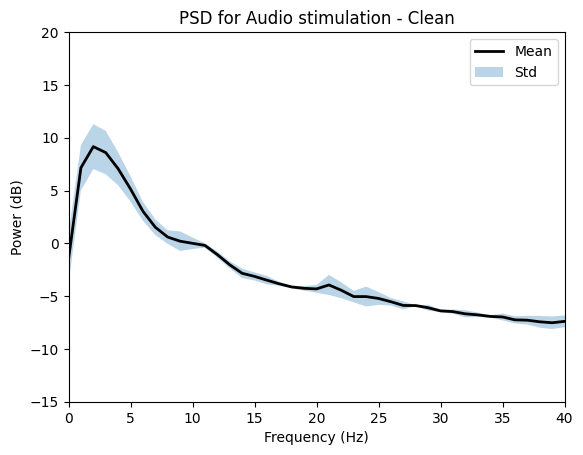

(5, 4, 129)


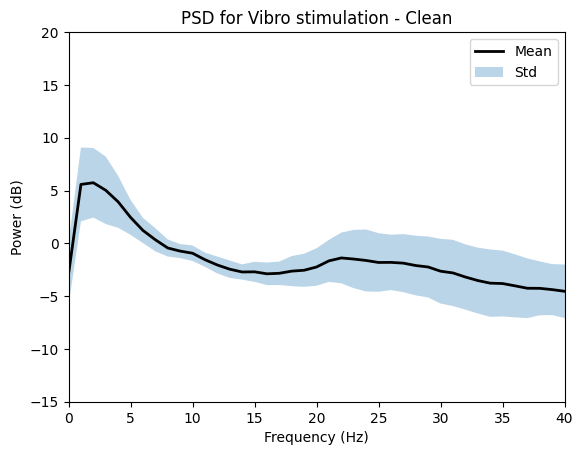

(14, 4, 129)


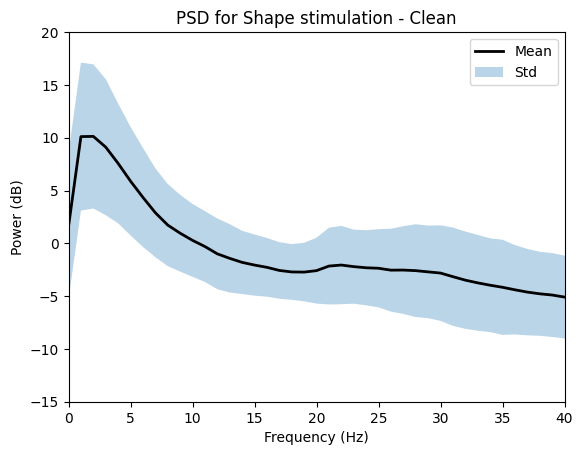

In [295]:
#print(psd_array.shape)
for modality in psd_data.keys():
    psd_array = np.array(psd_data[modality])
    psd_trials =10*np.log10(np.array(psd_array))
    psd_std = np.std(10*np.log10(np.array((psd_array))), axis=0)
    psd_mean = np.mean(10*np.log10(np.array((psd_array))), axis=0)
    print(psd_trials.shape)
    # for i in range(psd_trials.shape[0]):
    #     plt.plot(freqs, psd_trials[i][1],linewidth=1, label=f'trial{i}')
    plt.plot(freqs, psd_mean[1],linewidth=2, color="black", label=f'Mean')
    plt.fill_between(freqs, psd_mean[1] - psd_std[1], psd_mean[1] + psd_std[1], alpha=0.3, label='Std')

    plt.xlabel('Frequency (Hz)')
    plt.xlim(0,40)
    plt.ylim(-15,20)
    plt.ylabel('Power (dB)')
    plt.legend()
    plt.title(f"PSD for {modality} stimulation - Clean")
    plt.show()

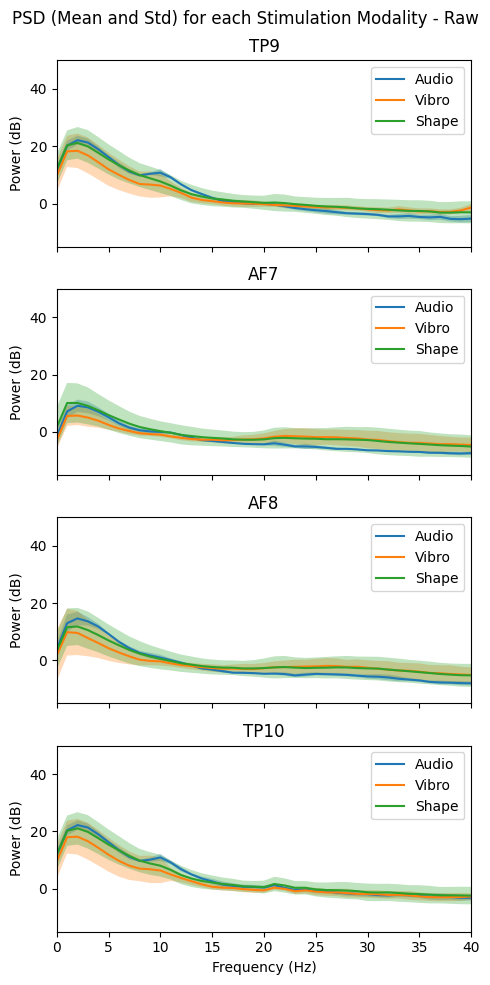

In [296]:

fig, axs = plt.subplots(4, 1, figsize=(5, 10), sharex=True)
channel_names = ['TP9', 'AF7', 'AF8', 'TP10']

# Plotting mean and std for each modality and channel
for modality in psd_data.keys():
    psd_array = np.array(psd_data[modality])
    #psd_trials =10*np.log10(np.array(psd_data[modality]))
    mean_psd = np.mean(10*np.log10(psd_array), axis=0)
    std_psd = np.std(10*np.log10(psd_array), axis=0)

    for ch in range(mean_psd.shape[0]):
        axs[ch].plot(freqs, mean_psd[ch], label=f'{modality}')
        axs[ch].fill_between(freqs, mean_psd[ch] - std_psd[ch], mean_psd[ch] + std_psd[ch], alpha=0.3)
        axs[ch].set_ylim(-15, 50)

# Set titles and labels for each subplot
for i, ax in enumerate(axs):
    ax.set_title(f'{channel_names[i]}')
    ax.set_ylabel('Power (dB)')
    ax.legend()

plt.xlim(0, 40) 
plt.ylim(-15, 50)


axs[-1].set_xlabel('Frequency (Hz)')
plt.suptitle("PSD (Mean and Std) for each Stimulation Modality - Raw")
plt.tight_layout()
 
plt.show()


-------
Plot Frequency Bands
--------

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Load the PSD data from the previously saved file
psd_data = np.load('psd_data.npy', allow_pickle=True).item()

# Define the frequency bands of interest
bands = {'delta': (0.1, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 40)}

# Initialize arrays to store the absolute and relative power for each channel and modality
abs_power = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
rel_power = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
abs_power_std = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
rel_power_std = {modality: np.zeros((len(bands), len(psd_data[modality][0]))) for modality in psd_data.keys()}
# Convert psd_data from list to numpy array
psd_data = {modality: np.array(data) for modality, data in psd_data.items()}


In [164]:
#------------SET if absolute or relative Power
absolute = True

# Compute the absolute and relative power for each frequency band and each channel and modality
for modality, psd_array in psd_data.items():
    for ch in range(len(psd_array[0])):
        for i, (fmin, fmax) in enumerate(bands.values()):
            freq_indices = np.where((freqs >= fmin) & (freqs <= fmax))[0]
            band_psd = (psd_array[:, ch, freq_indices])
            abs_power[modality][i, ch] = np.mean(10*np.log10(band_psd))
            abs_power_std[modality][i, ch] = np.std(10*np.log10(band_psd))
            # Percentage
            summation = []
            # for j in range(psd_array.shape[0]): 
            #     print(np.sum(psd_array[j, ch, :]))
            #     print(band_psd)
            #     summation.append(100*(band_psd) / np.sum(psd_array[j, :, :]))
            # print(np.array(summation).shape)
            rel_power[modality][i, ch] = np.mean(100*(band_psd) / np.sum(psd_array[:, ch]))
            rel_power_std[modality][i, ch] = np.std(100*(band_psd) / np.sum(psd_array[:, ch]))


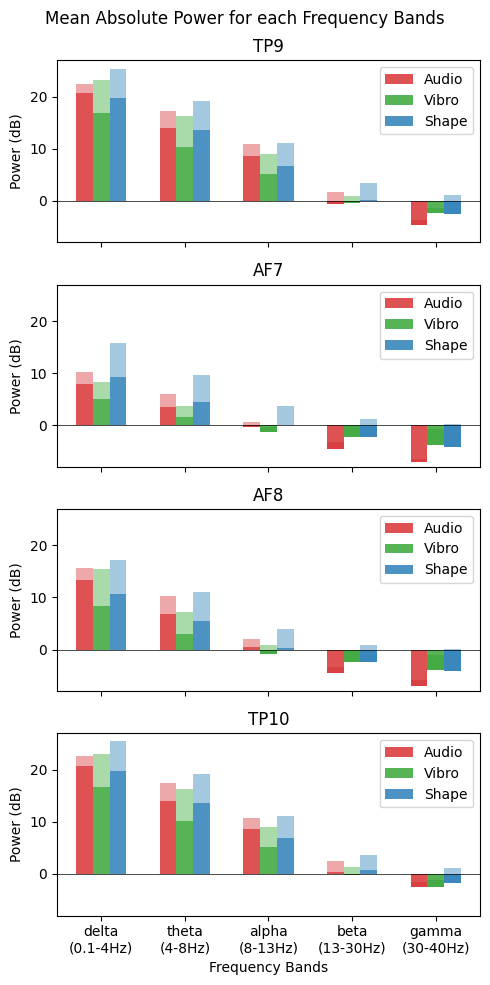

Percentage rel power distribution mean {'Audio': array([[2.68208827e+01, 3.54176980e+00, 4.64906086e+00, 4.71117474e+00],
       [6.25812699e+00, 1.33900912e+00, 1.23629968e+00, 1.22455720e+00],
       [9.32524566e-01, 4.62819726e-01, 2.24235989e-01, 2.95464069e-01],
       [1.26496232e-01, 1.82274828e-01, 6.99833098e-02, 4.46287881e-02],
       [1.31124339e-02, 9.93848898e-02, 3.92369298e-02, 2.05695518e-02]]), 'Vibro': array([[3.87176194, 1.89421423, 3.76534741, 3.83983726],
       [0.97700934, 0.72806387, 0.41787624, 0.992877  ],
       [0.14742634, 0.33263547, 0.09293891, 0.15753554],
       [0.02705579, 0.30696577, 0.06880612, 0.02856045],
       [0.0167573 , 0.24279919, 0.05463565, 0.01695844]]), 'Shape': array([[1.38278806, 1.2388116 , 1.32120345, 1.38373065],
       [0.37379209, 0.28606989, 0.36671177, 0.37371138],
       [0.0496592 , 0.05852725, 0.04359192, 0.04889518],
       [0.00841498, 0.03376942, 0.01893883, 0.00879225],
       [0.0050214 , 0.03032729, 0.01620471, 0.00511

In [161]:

# Plotting the mean and standard deviation of each channel as a bar chart
fig, axs = plt.subplots(4, 1, figsize=(5, 10), sharex=True)

#freq_labels = list(bands.keys())
freq_labels = [f'{key}\n({bands[key][0]}-{bands[key][1]}Hz)' for key in bands.keys()]

x = np.arange(len(freq_labels))
bar_width = 0.2
opacity = 0.8
opacity_std = 0.4
colors = [ 'tab:red', 'tab:green', 'tab:blue']
channel_names = ['TP9', 'AF7', 'AF8', 'TP10']

for ch in range(len(psd_data['Audio'][0])):
    for i, modality in enumerate(psd_data.keys()):
        if absolute:
            mean_power =(abs_power[modality][:, ch]) 
            std_power = (abs_power_std[modality][:, ch]) 
            axs[ch].set_ylim(-8,27)  
        else:
            mean_power =((rel_power[modality][:, ch])) 
            std_power = ((rel_power_std[modality][:, ch])) 
            #axs[ch].set_ylim(-3,12)
            
        axs[ch].bar(x + i * bar_width, mean_power, bar_width, alpha=opacity, color=colors[i],
                    label=modality) #, yerr=std_power)
        axs[ch].bar(x + i * bar_width, std_power, width=bar_width, align='center', bottom=mean_power,
        alpha=opacity_std, color=colors[i])
    axs[ch].legend()
    #axs[ch].legend(loc='lower right')
    axs[ch].set_ylabel('Power (dB)')
    axs[ch].set_xticks(x + bar_width * (len(psd_data.keys()) - 1) / 2)
    axs[ch].set_xticklabels(freq_labels)
    axs[ch].set_title(f'{channel_names[ch]}')
    
    axs[ch].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

if absolute:
    plt.suptitle("Mean Absolute Power for each Frequency Bands")
else:
    plt.suptitle("Mean Relative Power for each Frequency Bands")
plt.xlabel('Frequency Bands')
plt.tight_layout()
plt.show()

print("Percentage rel power distribution mean", rel_power)


---------------
Relative Power
------

In [276]:
# Compute the relative power for each frequency band and each channel and modality
psd_data = np.load('psd_data_all01.npy', allow_pickle=True).item()

# INPUT FORMAT: trials, channels, freq spectrum divided into bands
# OUTPUT FORMAT: modality, channels, mean percentage power for freq band
relative_power = {"Audio": [], "Vibro": [], "Shape": []} 
relative_power_std = {"Audio": [], "Vibro": [], "Shape": []} 
trials_relative_power = {"Audio": [], "Vibro": [], "Shape": []} 
n_trials = 9

for modality, psd_array in psd_data.items():
    #print(np.array(psd_array).shape)
    mean_psd = np.zeros((4, 5))
    std_psd = np.zeros((4, 5))
    trials_psd = np.zeros((4, 5, n_trials))
    for ch in range(len(psd_array[0])):
        #print("Next Channel")
        for i, (fmin, fmax) in enumerate(bands.values()):
            #print("Next Freq Band")
            freq_indices = np.where((freqs >= fmin) & (freqs <= fmax))[0]
            band_psd = np.sum(psd_array[:, ch, freq_indices], axis=1)
            #print(band_psd)
            tot_psd = (np.sum(psd_array[:, ch, :], axis=1))
            rel_psd = []
            #print(tot_psd)
            # print(np.array(tot_psd))
            for j in range(len(tot_psd)):
                #print(band_psd[j]*100 / tot_psd[j])
                rel_psd.append(band_psd[j]*100 / tot_psd[j])
            mean_psd[ch, i] = np.mean(rel_psd)
            std_psd[ch, i] = np.std(rel_psd)
            trials_psd[ch, i,:] = rel_psd[:n_trials]
    trials_relative_power[modality] = trials_psd
    relative_power[modality] = mean_psd
    relative_power_std[modality] = std_psd
relative_power_std = {key: np.round(value, decimals=2) for key, value in relative_power_std.items()}
relative_power = {key: np.round(value, decimals=2) for key, value in relative_power.items()}
trials_relative_power = {key: np.round(value, decimals=2) for key, value in trials_relative_power.items()}
print(relative_power)


# Save the PSD data dictionary to a file
np.save('psd_rel_trials01.npy', trials_relative_power)
print("PSD data saved to 'psd_rel_trials.npy'")               


TypeError: list indices must be integers or slices, not tuple

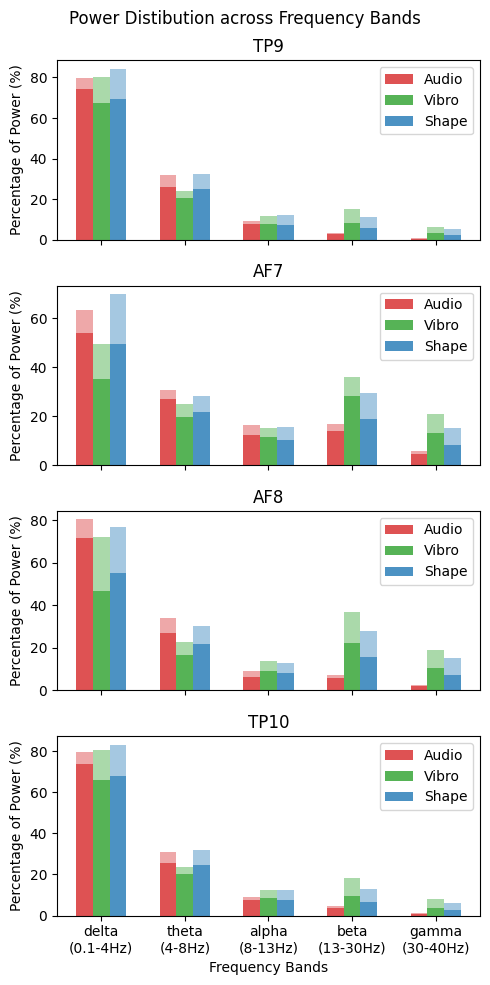

In [228]:
# Plotting the mean and standard deviation of each channel as a bar chart
fig, axs = plt.subplots(4, 1, figsize=(5, 10), sharex=True)

#freq_labels = list(bands.keys())
freq_labels = [f'{key}\n({bands[key][0]}-{bands[key][1]}Hz)' for key in bands.keys()]

x = np.arange(len(freq_labels))
bar_width = 0.2
opacity = 0.8
opacity_std = 0.4
colors = [ 'tab:red', 'tab:green', 'tab:blue']
channel_names = ['TP9', 'AF7', 'AF8', 'TP10']

for ch in range(len(psd_data['Audio'][0])):
    for i, modality in enumerate(psd_data.keys()):
        mean_power =(relative_power[modality][ch, :]) 
        std_power = (relative_power_std[modality][ch,:])  
        axs[ch].bar(x + i * bar_width, mean_power, bar_width, alpha=opacity, color=colors[i],
                    label=modality) #, yerr=std_power)
        axs[ch].bar(x + i * bar_width, std_power, width=bar_width, align='center', bottom=mean_power, alpha=opacity_std, color=colors[i])
    axs[ch].legend()
    #axs[ch].legend(loc='lower right')
    axs[ch].set_ylabel('Percentage of Power (%)')
    axs[ch].set_xticks(x + bar_width * (len(psd_data.keys()) - 1) / 2)
    axs[ch].set_xticklabels(freq_labels)
    axs[ch].set_title(f'{channel_names[ch]}')
    
    axs[ch].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.suptitle("Power Distibution across Frequency Bands")
plt.xlabel('Frequency Bands')
plt.tight_layout()
plt.show()



-----
Statistical Analysis Relative Power Distribution
---------

In [256]:
import scipy.stats as stats
from scipy.stats import f_oneway

# OUTPUT FORMAT: modality, channels, freq band
psd_rel_trials = np.load('psd_rel_trials.npy', allow_pickle=True).item()
num_channels = 4
p_values =  {"A-V": [], "A-S": [], "S-V": []} 
#print(psd_rel_trials)


In [262]:

# SET modality combo
modality1 = "Shape"
modality2 = "Vibro"
combo ="S-V"
matrix = np.zeros((4,5))
print(f"Statistical Difference between {modality1} - {modality2}")
for band in range(5):
    for channel in range(num_channels):
        # _, p_value = stats.levene(psd_rel_trials[modality1][channel,band, :],psd_rel_trials[modality2][channel,band, :], center='median')

        # # # Print the results
        # if p_value < 0.05:
        #     print("The variances are significantly different (p < 0.05), violating the assumption of homogeneous variance.", p_value)
        # else:
        #     print("The variances are not significantly different (p >= 0.05), supporting the assumption of homogeneous variance.", p_value)

        f_value, p_value = f_oneway(psd_rel_trials[modality1][channel,band, :],psd_rel_trials[modality2][channel,band, :])

        # print(f"ANOVA results for channel {channel}, band {band}")
        # print("p-values:", p_value )
        matrix [channel, band] = p_value
p_values[combo] = matrix
print(p_values)

Statistical Difference between Shape - Vibro
{'A-V': array([[0.4138407 , 0.22066015, 0.81289492, 0.27237268, 0.20368478],
       [0.15154442, 0.05823694, 0.56142028, 0.04140368, 0.12444125],
       [0.24664021, 0.06600958, 0.63671142, 0.15763047, 0.18078315],
       [0.42666962, 0.24608304, 0.65102189, 0.33689673, 0.30899039]]), 'A-S': array([[0.09340922, 0.60114034, 0.33408136, 0.04405846, 0.10349787],
       [0.00984131, 0.28021158, 0.35452993, 0.00927027, 0.00148427],
       [0.01193963, 0.20937615, 0.05449433, 0.00267592, 0.00493772],
       [0.05487834, 0.56963157, 0.28180057, 0.04996752, 0.08599792]]), 'S-V': array([[0.45728759, 0.11499691, 0.48919975, 0.87352032, 0.81340195],
       [0.67723535, 0.17430223, 0.11002091, 0.88609429, 0.40733297],
       [0.51365657, 0.15962429, 0.22165073, 0.6635456 , 0.93348588],
       [0.42245484, 0.1437115 , 0.52778487, 0.77026642, 0.94303147]])}
